In [2]:
import json
import os
import sys
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir,'src'))
sys.path[0] = src_dir
print(sys.path[0])
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.shift_graph_maker as sgm
import model.contagion as contagion

/home/staff/junelee/Research-Project/movie_propagation_reserve/src


In [3]:
%reload_ext autoreload
%autoreload 2
%load_ext snakeviz

%matplotlib inline

### plot for sir

In [4]:
from os import listdir
from os.path import isfile, join
import re

In [5]:
#read file
result_dir = '/home/projects/movie-network/result/contagion/temporal/real/'
file_list = [join(result_dir, f) for f in listdir(result_dir) if isfile(join(result_dir, f))]

In [6]:
producer_file = '/home/projects/movie-network/data/raw_data/movies.json'
with open(producer_file) as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)
role = 'producing'
role_key = role+'_gender_percentage'
all_movies = support.get_movies_df(role_key)
movie_period = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
producer_series = movie_period.producers.tolist()
all_producers = list(set([i[0] for sublist in producer_series for i in sublist]))
N = len(all_producers)

Loaded IMDb movies producing_gender_percentage


In [7]:
def get_parameters(file_names):
    """
    get list of parameters from the file
    """
    param_list = []
    for path in file_names:
        f_name = os.path.basename(path)
        p = re.compile(r'p[0-9]+\_d[0-9]+\_t[0-9]+')
        param = p.search(f_name).group()
        param_list.append(param)
    param_list = list(set(param_list))
    return param_list

In [8]:
param_list = get_parameters(file_list)

In [9]:
def read_files_w_parameter(result_dir, param,N=1):
    '''
    read files with the given parameter divided by N, either 1 or total number of players
    '''
    df_list = []
    file_names = [join(result_dir, f) for f in listdir(result_dir) if isfile(join(result_dir, f))]
    file_param = [fs for fs in file_names if param in fs]
    v = re.compile(r'ver_[0-9]+')
    for fs in file_param:
        df = pd.read_json(fs, orient='split')
        ver = v.search(fs).group()
        df.name = ver
        #divide df by N except for the year column
        df.loc[:,df.columns != 'year'] = df.loc[:,df.columns != 'year']/N
        #rename columns to drop duplicate columns
        rename_col = {col:'{}_{}'.format(col, ver) for col in df.columns}
        df = df.rename(columns=rename_col)
        df_list.append(df)
        if len(df_list) == 6:
            break
    return df_list

In [10]:

df_list = read_files_w_parameter(result_dir, param_list[1],N)
df_list[0]

,year_ver_16,0_ver_16,1_ver_16,2_ver_16,3_ver_16,4_ver_16,5_ver_16,6_ver_16,7_ver_16,8_ver_16,...,490_ver_16,491_ver_16,492_ver_16,493_ver_16,494_ver_16,495_ver_16,496_ver_16,497_ver_16,498_ver_16,499_ver_16
0,1990,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,...,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786
1,1990,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,...,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786
2,1990,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,...,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786
3,1990,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,...,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655
4,1990,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,...,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655
5,1990,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,...,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655
6,1990,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,...,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176
7,1990,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,...,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697
8,1990,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,...,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697
9,1990,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,...,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697


In [11]:
param = param_list[1]

In [12]:
df_test = pd.concat(df_list, axis=1)

In [13]:
column_list = df_test.columns.tolist()
for i in column_list:
    if 'year' in i:
        print(i)
len(column_list)

year_ver_16
year_ver_0
year_ver_6
year_ver_5
year_ver_8
year_ver_11


3006

In [14]:
#check if all year columns have the same value
year_columns = [col for col in df_test.columns if 'year' in col]
#check if the columns are same to reference column
year_same_df = df_test[year_columns].eq(df_test['year_ver_0'], axis=0).all(axis=0)
#check if all columns are same
year_same_df.all() #supposed return 

True

In [15]:
none_year_columns = [c for c in df_test.columns if c not in year_columns]
df_test[none_year_columns]

,0_ver_16,1_ver_16,2_ver_16,3_ver_16,4_ver_16,5_ver_16,6_ver_16,7_ver_16,8_ver_16,9_ver_16,...,490_ver_11,491_ver_11,492_ver_11,493_ver_11,494_ver_11,495_ver_11,496_ver_11,497_ver_11,498_ver_11,499_ver_11
0,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,...,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786
1,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,...,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786
2,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,0.184786,...,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134
3,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,...,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134
4,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,...,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134,0.185134
5,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,0.185655,...,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002
6,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,0.186176,...,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002,0.186002
7,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,...,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349
8,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,...,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349
9,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,0.186697,...,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349,0.186349


In [16]:
def mean_ci(df, high=0.975, low=0.025):
    mean = df.mean(axis=1).tolist()
    low_ci = df.quantile(low, axis=1).tolist()
    high_ci = df.quantile(high, axis=1).tolist()
    return mean, low_ci, high_ci

def median_ci(df, high=0.975, low=0.025):
    mean = df.median(axis=1).tolist()
    low_ci = df.quantile(low, axis=1).tolist()
    high_ci = df.quantile(high, axis=1).tolist()
    return mean, low_ci, high_ci


In [17]:
mean, low_ci, high_ci = median_ci(df_test[none_year_columns])

In [18]:
#def make_mean_df()
df_mean = pd.DataFrame(index=df_test.index)
df_mean['mean'] = mean
df_mean['low_ci'] = low_ci
df_mean['high_ci'] = high_ci
df_mean['year'] = df_test[year_columns[0]]

In [19]:
df_mean

,mean,low_ci,high_ci,year
0,0.184786,0.184786,0.184786,1990
1,0.184786,0.184786,0.185134,1990
2,0.185134,0.184786,0.186002,1990
3,0.185307,0.184786,0.186523,1990
4,0.186002,0.185134,0.186697,1990
5,0.186263,0.185134,0.187912,1990
6,0.186349,0.185134,0.187912,1990
7,0.186610,0.185134,0.187912,1990
8,0.186610,0.185134,0.188607,1990
9,0.186870,0.185134,0.188607,1990


In [20]:
next(os.walk('/home/projects/movie-network/result/mean/projected/sequential/'))[1]

['unweighted_agg_1', 'unweighted_agg_2']

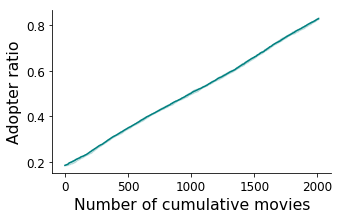

In [21]:
fontsize=12
color='teal'
#plot the figure:
fig, ax = plt.subplots(figsize=(5,3))
#get the bipartite data:
#plot bipartite results
ax.plot(df_test.index, mean, color=color)
ax.fill_between(df_test.index, low_ci, high_ci, color=color, alpha=0.2)
#figure style
ax.set_ylabel('Adopter ratio', fontsize=1.3*fontsize)
ax.set_xlabel('Number of cumulative movies', fontsize=1.3*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig()

In [22]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [24]:
hahaha = pd.read_json('/home/projects/movie-network/result/contagion/temporal/real/contagion_0_p30_d100_t100_ver_19.json', orient='split')

In [25]:
hahaha

,year,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,1990,1064,1064,1064,1064,1064,1064,1064,1064,1064,...,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064
1,1990,1068,1065,1068,1068,1068,1068,1067,1068,1068,...,1068,1068,1066,1068,1068,1068,1067,1068,1068,1068
2,1990,1074,1069,1072,1075,1075,1074,1072,1072,1070,...,1074,1073,1070,1074,1073,1075,1073,1073,1073,1072
3,1990,1074,1069,1072,1075,1075,1074,1072,1072,1070,...,1074,1073,1070,1074,1073,1075,1073,1073,1073,1072
4,1990,1076,1071,1074,1077,1077,1076,1074,1074,1072,...,1076,1075,1072,1075,1075,1077,1075,1075,1075,1074
5,1990,1076,1071,1074,1077,1077,1076,1074,1074,1072,...,1076,1075,1072,1075,1075,1077,1075,1075,1075,1074
6,1990,1076,1071,1074,1077,1077,1076,1074,1074,1072,...,1076,1075,1072,1075,1075,1077,1075,1075,1075,1074
7,1990,1076,1071,1074,1077,1077,1076,1074,1074,1072,...,1076,1075,1072,1075,1075,1077,1075,1075,1075,1074
8,1990,1076,1071,1074,1077,1077,1076,1074,1074,1072,...,1076,1075,1072,1075,1075,1077,1075,1075,1075,1074
9,1990,1076,1071,1074,1077,1077,1076,1074,1074,1072,...,1076,1075,1072,1075,1075,1077,1075,1075,1075,1074


In [26]:
hehehe = pd.read_json('/home/projects/movie-network/result/contagion/projection/sequential/unweighted/agg_1/contagion_agg_1_p20_d100_t100_ver_0.json', orient='split')

In [27]:
hehehe

,year,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,"[1989, 1990]",1064,1064,1064,1064,1064,1064,1064,1064,1064,...,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064
1,"[1989, 1990]",1068,1065,1068,1066,1067,1067,1067,1068,1066,...,1066,1066,1067,1067,1064,1068,1070,1066,1067,1065
2,"[1989, 1990]",1070,1068,1071,1070,1070,1070,1067,1071,1069,...,1070,1067,1067,1070,1068,1072,1073,1066,1070,1068
3,"[1989, 1990]",1071,1070,1074,1072,1073,1074,1068,1073,1069,...,1070,1068,1070,1070,1072,1072,1076,1069,1070,1071
4,"[1989, 1990]",1075,1071,1077,1072,1074,1080,1072,1074,1072,...,1073,1070,1071,1072,1073,1074,1079,1073,1071,1072
5,"[1989, 1990]",1078,1074,1078,1079,1077,1084,1074,1078,1073,...,1077,1072,1073,1074,1075,1076,1083,1075,1071,1072
6,"[1989, 1990]",1078,1077,1081,1079,1081,1087,1077,1081,1076,...,1080,1075,1074,1078,1078,1076,1083,1078,1072,1075
7,"[1989, 1990]",1079,1080,1082,1083,1084,1090,1080,1084,1078,...,1084,1078,1078,1078,1078,1078,1089,1082,1075,1076
8,"[1989, 1990]",1082,1082,1083,1087,1084,1091,1081,1087,1078,...,1091,1080,1078,1081,1081,1078,1090,1085,1078,1079
9,"[1989, 1990]",1085,1086,1087,1088,1085,1091,1083,1087,1081,...,1096,1082,1082,1084,1083,1082,1092,1088,1081,1082
